# Downsample dataset

The downsampling follows these criteria:
1. The papers are from 2010 to present.
2. The papers are relevant to Drosophila neurobiology (likely to contain descriptions of neuronal cell types)

In [1]:
import sys
sys.path.append("../python/extraction")

from utils import Paper
import pandas as pd
import matplotlib.pyplot as plt
from langchain_openai import ChatOpenAI

Text(0.5, 1.0, 'Publications by Year')

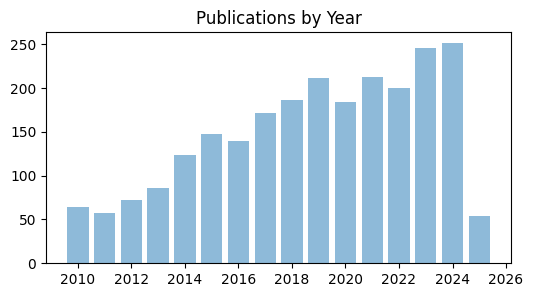

In [2]:
df = pd.read_csv("../assets/pubmed_search_results.csv")
df = df[df["Publication Year"] >= 2010]
df = df.dropna(subset=["full_text_path"])

# Count the number of papers per year
year_counts = df["Publication Year"].value_counts().sort_index()
plt.figure(figsize=(6, 3))
plt.bar(year_counts.index, year_counts.values, alpha=0.5, label='Total Publications')
plt.title("Publications by Year")

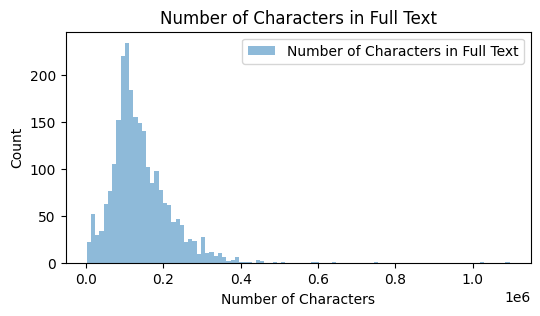

In [3]:
# Number of characters in the full text (json file)
df["num_chars"] = df["full_text_path"].apply(lambda x: len(open(f"../{x}").read()))

# Plot the number of characters in the full text
plt.figure(figsize=(6, 3))
plt.hist(df["num_chars"], bins=100, alpha=0.5, label='Number of Characters in Full Text')
plt.title("Number of Characters in Full Text")
plt.xlabel("Number of Characters")
plt.ylabel("Count")
plt.legend()
plt.show()

In [4]:
# Filter out 5% of the papers with the least characters
df = df.sort_values(by="num_chars", ascending=True)
sub_df = df.iloc[:int(len(df) * 0.95)]
print(f"Number of papers after filtering: {len(sub_df)}")

Number of papers after filtering: 2285


In [8]:
# Downsample 100 papers randomly
sub_df = sub_df.sample(100, random_state=42)

In [9]:
# Convert the pmids to papers
papers = [Paper.from_pmid(pmid) for pmid in sub_df["PMID"]]

In [11]:
# Check if the paper contains title and abstract
for paper in papers:
    if paper.title is None or paper.abstract is None:
        print(f"Paper {paper.pmid} has no title or abstract")
        print(paper.to_str())
        print('-' * 100)

Paper 29414942 has no title or abstract
Title: Mechanical regulation of stem cell differentiation through stretch-activated Piezo channel
Abstract: None
INTRO 1: Somatic stem cells constantly adjust their self-renewal and lineage commitment by integrating various environmental cues to maintain tissue homeostasis. While numerous chemical and biological signals have been identified to regulate stem cell behaviors, whether stem cells can directly sense mechanical signals in vivo remains unclear. Here, we show that mechanical stress regulates stem cell differentiation in the adult Drosophila midgut through the stretch-activated ion channel Piezo. We find that Piezo is specifically expressed in previously unidentified enteroendocrine precursor (EP) cells which have reduced proliferation ability and are destined to become enteroendocrine cells (EEs). Loss of Piezo activity reduces EE generation in the adult midgut. Meanwhile, ectopic expression of Piezo in all stem cells triggers both cell p

In [14]:
# Check if the paper is relevant by llm
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)
system_prompt = """
You are a neurobiologist.
You are given a paper, but only the title, abstract, introduction, and results sections.
You need to determine if the paper describes any neuronal cell types of Drosophila.
If you are confident that it does, respond with "Yes". Otherwise, respond with "No".
Then, gives an explanation of your reasoning on next line.
"""

# Check if the paper is relevant by llm, using batch processing
messages = []
for paper in papers:
    messages.append([("system", system_prompt), ("user", paper.to_str())])

# Get the responses
responses = llm.batch(
    messages, config={"max_concurrency": 5}
)  # Limit concurrent API calls

In [15]:
results = [response.content.lower().startswith("yes") for response in responses]

# Count the number of relevant papers
relevant_count = sum(results)
print(f"Number of relevant papers: {relevant_count}/{len(papers)}")

Number of relevant papers: 90/100


In [16]:
sub_df = sub_df[results]

In [18]:
# Save the downsampled papers using pmids
sub_df["PMID"].to_csv("../assets/downsampled_pmids.txt", index=False, header=False)
